# Creating a large database

In this section, we will take a look at techniques for creating a database for a large file or number of files.

In [1]:
import pandas as pd
from dfply import *

## Creating a large database with `pandas`

1. Read the first chunk and build cleaning functions.
2. Write the first section to a `db`
3. Use a for loop to <br>
    a. read a chuck<br>
    b. clean the chunk<br>
    c. append the chunk to the `db`<br>

## Example - Creating a Uber database with dateparts

Now we will use `pandas` to read, process and write the Uber data to a database.

## Step 1 - Inspect/clean the first chunk

It is important to automate the type specification and cleaning process. (based on previous work shown above)

#### Imports

In [2]:
from toolz import first
from calendar import day_name
import numpy as np
import pandas as pd
from dfply import *

#### default values

In [3]:
c_size = 10000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)

#### Create a data frame iterator and pull off the first chunk

In [4]:
c_size = 10000
file = "./data/uber-raw-data-apr14.csv"
df_iter = pd.read_csv(file, 
                      header=0, names=new_names,
                      parse_dates=date_cols,
                      sep=',',
                      engine='python',
                      chunksize=c_size)
first_chunk = next(df_iter)
first_chunk.head()

,date,lat,lon,base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


#### Expression for adding various date parts

In [5]:
from functoolz import pipeable
(first_chunk 
 >> mutate(weekday = X.date.dt.weekday_name,
           weekofyear = X.date.dt.weekofyear,
           dayofyear = X.date.dt.dayofyear,
           year = X.date.dt.year,
           month = X.date.dt.month_name(),
           day = X.date.dt.day,
           hour = X.date.dt.hour)
 >> head)

,date,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday,14,91,2014,April,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday,14,91,2014,April,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday,14,91,2014,April,1,0


#### Create a functions for adding dateparts

In [6]:
from functoolz import pipeable
add_dateparts = pipeable(lambda df: (df >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                            weekofyear = X.date.dt.weekofyear,
                                            dayofyear = X.date.dt.dayofyear,
                                            year = X.date.dt.year,
                                            month = X.date.dt.month_name(),
                                            day = X.date.dt.day,
                                            hour = X.date.dt.hour)
                                    >> drop(X.date)))
processed_first_chunk = first_chunk >> add_dateparts
processed_first_chunk.head(2)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0


## Adding a primary key

* **Recall:** Primary keys need to be unique
* We will need to adjust the `id` column
* Make sure first `id` of next chunk is one more than the last

#### A function for adding an `id` column with a given starting value

In [7]:
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(start, start + len(df))
                                              )))

#### Playing around with different chunk indices

In [8]:
from dfply import head
i = 0
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) 
 >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,0


In [9]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


In [10]:
i = 1
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,10000


In [11]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,19999


In [12]:
i = 2
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,20000


In [13]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,29999


#### Compose the helper functions

In [14]:
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(i*c_size))
first_chunk >> process_chunk(0) >> tail(1)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


#### Get the `sqlalchemy` types

In [15]:
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk)
sql_types

{'lat': sqlalchemy.sql.sqltypes.Float,
 'lon': sqlalchemy.sql.sqltypes.Float,
 'base': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer,
 'month': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer}

## Step 2 - Read, process, and write the first chunk

Use `if_exists='replace'` on this first chuck.

#### Create a new database

In [55]:
!rm ./databases/uber.db

In [56]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

#### Get the sql schema and create the table

In [57]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	lat FLOAT, 
	lon FLOAT, 
	base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




## Step 3 - Getting the `df` iterator and read in each processed chunk


In [58]:
c_size = 10000
df_iter = enumerate(pd.read_csv("./data/uber-raw-data-apr14.csv", 
                                header=0, names=new_names, 
                                parse_dates=date_cols,
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [59]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0
writing chunk 1
writing chunk 2
writing chunk 3
writing chunk 4
writing chunk 5
writing chunk 6
writing chunk 7
writing chunk 8
writing chunk 9
writing chunk 10
writing chunk 11
writing chunk 12
writing chunk 13
writing chunk 14
writing chunk 15
writing chunk 16
writing chunk 17
writing chunk 18
writing chunk 19
writing chunk 20
writing chunk 21
writing chunk 22
writing chunk 23
writing chunk 24
writing chunk 25
writing chunk 26
writing chunk 27
writing chunk 28
writing chunk 29
writing chunk 30
writing chunk 31
writing chunk 32
writing chunk 33
writing chunk 34
writing chunk 35
writing chunk 36
writing chunk 37
writing chunk 38
writing chunk 39
writing chunk 40
writing chunk 41
writing chunk 42
writing chunk 43
writing chunk 44
writing chunk 45
writing chunk 46
writing chunk 47
writing chunk 48
writing chunk 49
writing chunk 50
writing chunk 51
writing chunk 52
writing chunk 53
writing chunk 54
writing chunk 55
writing chunk 56


## Step 4 - Query the database to test the results


In [60]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [61]:
from sqlalchemy import select, func
stmt = (select([Uber.weekday, 
               func.count(Uber.weekday).label('cnt')])
        .group_by(Uber.weekday))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts

,weekday,cnt
0,Friday,90303
1,Monday,60861
2,Saturday,77218
3,Sunday,51251
4,Thursday,85067
5,Tuesday,91185
6,Wednesday,108631


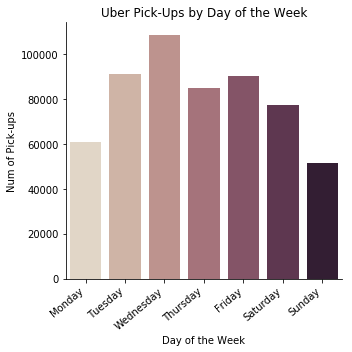

In [62]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="bar", 
               order=day_name,
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## <font color="red"> Exercise 3 </font>

Add the data from the other 5 months to the database.  To do this

1. Use `glob` to get all the file names (filter out april).
2. Write a double `for` loop where
    a. The outer loop is over the file names
    b. The inner loop write each file, in chunks, to the database.
3. You will need keep track of the number of rows added using an accumulator.


Compute and visualize the hourly frequencies for Uber pick-ups for all 6 months, this time with `SQL` queries.

**Hint:** Recall that the primary key column, `id`, needs unique values.  You will need to adjust the `id` column in each chunk using `rows_so_far` (see below).

In [63]:
rows_so_far = cnts.cnt.sum()
rows_so_far

564516

In [64]:
from glob import glob
files = glob('./data/uber/uber-trip-data/uber-raw-data-[ajms][uae]*.csv')
files

['./data/uber/uber-trip-data/uber-raw-data-aug14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 './data/uber/uber-trip-data/uber-raw-data-may14.csv',
 './data/uber/uber-trip-data/uber-raw-data-sep14.csv']

In [65]:
process_chunk2 = pipeable(lambda start, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(start))

In [66]:
nrows = rows_so_far
for f in files:
    c_size = 10000
    print('processing file {0}'.format(f))
    df_iter = enumerate(pd.read_csv(f, 
                                header=0, names=new_names, 
                                parse_dates=date_cols,
                                chunksize=c_size,
                                sep=',',
                                engine='python'))
    for i, chunk in df_iter:
        
        processed_chunk = chunk >> process_chunk2(nrows)
        #print('writing chunk {0}'.format(i))
        #print('nrows {0}'.format(nrows))
        #print('head {0}'.format(processed_chunk.head(2)))
        #print('tail {0}'.format(processed_chunk.tail(2)))


        processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')
        nrows = nrows + len(chunk)

processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv
writing chunk 0
nrows 564516
head        lat      lon    base weekday  weekofyear  dayofyear  year   month  day  \
0  40.7366 -73.9906  B02512  Friday          31        213  2014  August    1   
1  40.7260 -73.9918  B02512  Friday          31        213  2014  August    1   

   hour      id  
0     0  564516  
1     0  564517  
tail           lat      lon    base   weekday  weekofyear  dayofyear  year   month  \
9998  40.7817 -73.9847  B02512  Saturday          32        221  2014  August   
9999  40.7829 -73.9529  B02512  Saturday          32        221  2014  August   

      day  hour      id  
9998    9    16  574514  
9999    9    16  574515  
writing chunk 1
nrows 574516
head            lat      lon    base   weekday  weekofyear  dayofyear  year  \
10000  40.7214 -73.9838  B02512  Saturday          32        221  2014   
10001  40.7565 -73.9831  B02512  Saturday          32        221  2014   

        month  da

writing chunk 12
nrows 684516
head             lat      lon    base  weekday  weekofyear  dayofyear  year  \
120000  40.7500 -73.9834  B02598  Tuesday          33        224  2014   
120001  40.7479 -73.9847  B02598  Tuesday          33        224  2014   

         month  day  hour      id  
120000  August   12    17  684516  
120001  August   12    17  684517  
tail             lat      lon    base    weekday  weekofyear  dayofyear  year  \
129998  40.7543 -73.9803  B02598  Wednesday          33        225  2014   
129999  40.7556 -73.9860  B02598  Wednesday          33        225  2014   

         month  day  hour      id  
129998  August   13    20  694514  
129999  August   13    20  694515  
writing chunk 13
nrows 694516
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
130000  40.7341 -74.0029  B02598  Wednesday          33        225  2014   
130001  40.7702 -73.8648  B02598  Wednesday          33        225  2014   

         month  day  hour   

writing chunk 24
nrows 804516
head             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
240000  40.6403 -74.0118  B02598  Friday          35        241  2014  August   
240001  40.7200 -74.0054  B02598  Friday          35        241  2014  August   

        day  hour      id  
240000   29    23  804516  
240001   29    23  804517  
tail             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
249998  40.8273 -73.9427  B02598  Sunday          35        243  2014  August   
249999  40.6449 -73.7823  B02598  Sunday          35        243  2014  August   

        day  hour      id  
249998   31    19  814514  
249999   31    19  814515  
writing chunk 25
nrows 814516
head             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
250000  40.6922 -73.9864  B02598  Sunday          35        243  2014  August   
250001  40.7746 -73.9822  B02598  Sunday          35        243  2014  August   

        day  hour      id

writing chunk 36
nrows 924516
head             lat      lon    base   weekday  weekofyear  dayofyear  year  \
360000  40.7599 -73.9805  B02617  Saturday          32        221  2014   
360001  40.7726 -73.9465  B02617  Saturday          32        221  2014   

         month  day  hour      id  
360000  August    9    18  924516  
360001  August    9    18  924517  
tail             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
369998  40.7721 -73.9610  B02617  Sunday          32        222  2014  August   
369999  40.7398 -73.9034  B02617  Sunday          32        222  2014  August   

        day  hour      id  
369998   10    15  934514  
369999   10    15  934515  
writing chunk 37
nrows 934516
head             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
370000  40.7432 -73.9934  B02617  Sunday          32        222  2014  August   
370001  40.7583 -73.9895  B02617  Sunday          32        222  2014  August   

        day  hour  

writing chunk 48
nrows 1044516
head            lat      lon    base    weekday  weekofyear  dayofyear  year  \
480000  40.773 -73.9666  B02617  Wednesday          34        232  2014   
480001  40.773 -73.9666  B02617  Wednesday          34        232  2014   

         month  day  hour       id  
480000  August   20    10  1044516  
480001  August   20    10  1044517  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year  \
489998  40.7057 -73.9446  B02617  Thursday          34        233  2014   
489999  40.6104 -73.9703  B02617  Thursday          34        233  2014   

         month  day  hour       id  
489998  August   21     6  1054514  
489999  August   21     6  1054515  
writing chunk 49
nrows 1054516
head             lat      lon    base   weekday  weekofyear  dayofyear  year  \
490000  40.6448 -73.7815  B02617  Thursday          34        233  2014   
490001  40.7439 -73.9919  B02617  Thursday          34        233  2014   

         month  day  ho

writing chunk 60
nrows 1164516
head             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
600000  40.7334 -74.0049  B02617  Sunday          35        243  2014  August   
600001  40.7292 -73.9812  B02617  Sunday          35        243  2014  August   

        day  hour       id  
600000   31    10  1164516  
600001   31    10  1164517  
tail             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
609998  40.7560 -73.9821  B02682  Friday          31        213  2014  August   
609999  40.7745 -73.9639  B02682  Friday          31        213  2014  August   

        day  hour       id  
609998    1    12  1174514  
609999    1    12  1174515  
writing chunk 61
nrows 1174516
head             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
610000  40.7470 -73.9816  B02682  Friday          31        213  2014  August   
610001  40.7524 -73.9932  B02682  Friday          31        213  2014  August   

        day  hour

writing chunk 72
nrows 1284516
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
720000  40.7421 -73.9340  B02682  Wednesday          34        232  2014   
720001  40.7115 -74.0157  B02682  Wednesday          34        232  2014   

         month  day  hour       id  
720000  August   20    15  1284516  
720001  August   20    15  1284517  
tail             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
729998  40.7558 -73.9864  B02682  Friday          34        234  2014  August   
729999  40.7720 -73.9900  B02682  Friday          34        234  2014  August   

        day  hour       id  
729998   22     4  1294514  
729999   22     4  1294515  
writing chunk 73
nrows 1294516
head             lat      lon    base weekday  weekofyear  dayofyear  year   month  \
730000  40.7287 -73.9993  B02682  Friday          34        234  2014  August   
730001  40.7741 -73.9486  B02682  Friday          34        234  2014  August   

        

writing chunk 1
nrows 1403791
head            lat      lon    base weekday  weekofyear  dayofyear  year month  \
10000  40.7657 -73.9760  B02512  Friday          28        192  2014  July   
10001  40.7419 -73.9804  B02512  Friday          28        192  2014  July   

       day  hour       id  
10000   11    13  1403791  
10001   11    13  1403792  
tail            lat      lon    base   weekday  weekofyear  dayofyear  year month  \
19998  40.7333 -73.9988  B02512  Saturday          29        200  2014  July   
19999  40.7442 -73.9842  B02512  Saturday          29        200  2014  July   

       day  hour       id  
19998   19    16  1413789  
19999   19    16  1413790  
writing chunk 2
nrows 1413791
head            lat      lon    base   weekday  weekofyear  dayofyear  year month  \
20000  40.8407 -74.2011  B02512  Saturday          29        200  2014  July   
20001  40.7112 -74.0054  B02512  Saturday          29        200  2014  July   

       day  hour       id  
20000   19  

writing chunk 13
nrows 1523791
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
130000  40.7405 -73.9862  B02598  Monday          29        195  2014  July   
130001  40.7568 -73.9824  B02598  Monday          29        195  2014  July   

        day  hour       id  
130000   14    12  1523791  
130001   14    12  1523792  
tail             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
139998  40.9075 -74.0983  B02598  Tuesday          29        196  2014  July   
139999  40.7277 -74.0074  B02598  Tuesday          29        196  2014  July   

        day  hour       id  
139998   15    14  1533789  
139999   15    14  1533790  
writing chunk 14
nrows 1533791
head             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
140000  40.6811 -73.9759  B02598  Tuesday          29        196  2014  July   
140001  40.8040 -73.9659  B02598  Tuesday          29        196  2014  July   

        day  hour       id  


writing chunk 25
nrows 1643791
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
250000  40.6430 -73.9648  B02598  Monday          31        209  2014  July   
250001  40.7494 -73.9818  B02598  Monday          31        209  2014  July   

        day  hour       id  
250000   28    13  1643791  
250001   28    13  1643792  
tail             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
259998  40.7937 -73.9693  B02598  Tuesday          31        210  2014  July   
259999  40.7594 -73.9926  B02598  Tuesday          31        210  2014  July   

        day  hour       id  
259998   29    19  1653789  
259999   29    19  1653790  
writing chunk 26
nrows 1653791
head             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
260000  40.7170 -73.9423  B02598  Tuesday          31        210  2014  July   
260001  40.7529 -73.9858  B02598  Tuesday          31        210  2014  July   

        day  hour       id  


writing chunk 37
nrows 1763791
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
370000  40.7773 -73.9483  B02617  Saturday          28        193  2014  July   
370001  40.6387 -73.9876  B02617  Saturday          28        193  2014  July   

        day  hour       id  
370000   12    18  1763791  
370001   12    18  1763792  
tail             lat      lon    base weekday  weekofyear  dayofyear  year month  \
379998  40.6853 -73.9196  B02617  Sunday          28        194  2014  July   
379999  40.6776 -73.9639  B02617  Sunday          28        194  2014  July   

        day  hour       id  
379998   13    19  1773789  
379999   13    19  1773790  
writing chunk 38
nrows 1773791
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
380000  40.6447 -73.7824  B02617  Sunday          28        194  2014  July   
380001  40.7439 -73.9781  B02617  Sunday          28        194  2014  July   

        day  hour       id  


writing chunk 49
nrows 1883791
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
490000  40.7218 -73.9874  B02617  Wednesday          30        204  2014   
490001  40.7585 -73.9735  B02617  Wednesday          30        204  2014   

       month  day  hour       id  
490000  July   23    18  1883791  
490001  July   23    18  1883792  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
499998  40.6620 -73.9577  B02617  Thursday          30        205  2014  July   
499999  40.7412 -73.9847  B02617  Thursday          30        205  2014  July   

        day  hour       id  
499998   24    14  1893789  
499999   24    14  1893790  
writing chunk 50
nrows 1893791
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
500000  40.6448 -73.7821  B02617  Thursday          30        205  2014  July   
500001  40.7498 -73.9741  B02617  Thursday          30        205  2014  July   

        day  h

writing chunk 61
nrows 2003791
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
610000  40.6952 -74.1776  B02682  Friday          27        185  2014  July   
610001  40.7862 -73.9759  B02682  Friday          27        185  2014  July   

        day  hour       id  
610000    4     0  2003791  
610001    4     0  2003792  
tail             lat      lon    base weekday  weekofyear  dayofyear  year month  \
619998  40.6637 -73.9945  B02682  Monday          28        188  2014  July   
619999  40.6460 -73.7767  B02682  Monday          28        188  2014  July   

        day  hour       id  
619998    7     4  2013789  
619999    7     4  2013790  
writing chunk 62
nrows 2013791
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
620000  40.7229 -74.0013  B02682  Monday          28        188  2014  July   
620001  40.7623 -73.9864  B02682  Monday          28        188  2014  July   

        day  hour       id  
620000

writing chunk 73
nrows 2123791
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
730000  40.6719 -73.9639  B02682  Wednesday          30        204  2014   
730001  40.7730 -73.8857  B02682  Wednesday          30        204  2014   

       month  day  hour       id  
730000  July   23    14  2123791  
730001  July   23    14  2123792  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
739998  40.7253 -74.0002  B02682  Thursday          30        205  2014  July   
739999  40.7438 -74.0022  B02682  Thursday          30        205  2014  July   

        day  hour       id  
739998   24    18  2133789  
739999   24    18  2133790  
writing chunk 74
nrows 2133791
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
740000  40.7673 -73.9644  B02682  Thursday          30        205  2014  July   
740001  40.7522 -73.9934  B02682  Thursday          30        205  2014  July   

        day  h

writing chunk 5
nrows 2239912
head            lat      lon    base  weekday  weekofyear  dayofyear  year month  \
50000  40.7556 -73.9702  B02598  Tuesday          23        154  2014  June   
50001  40.7472 -74.0099  B02598  Tuesday          23        154  2014  June   

       day  hour       id  
50000    3    16  2239912  
50001    3    16  2239913  
tail            lat      lon    base    weekday  weekofyear  dayofyear  year month  \
59998  40.7451 -73.9948  B02598  Wednesday          23        155  2014  June   
59999  40.7601 -73.9787  B02598  Wednesday          23        155  2014  June   

       day  hour       id  
59998    4    17  2249910  
59999    4    17  2249911  
writing chunk 6
nrows 2249912
head            lat      lon    base    weekday  weekofyear  dayofyear  year month  \
60000  40.7567 -73.9740  B02598  Wednesday          23        155  2014  June   
60001  40.7514 -73.9763  B02598  Wednesday          23        155  2014  June   

       day  hour       id  
600

writing chunk 17
nrows 2359912
head             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
170000  40.7256 -74.0046  B02598  Tuesday          25        168  2014  June   
170001  40.7571 -73.9742  B02598  Tuesday          25        168  2014  June   

        day  hour       id  
170000   17    16  2359912  
170001   17    16  2359913  
tail             lat      lon    base    weekday  weekofyear  dayofyear  year  \
179998  40.7145 -73.9907  B02598  Wednesday          25        169  2014   
179999  40.6950 -74.1774  B02598  Wednesday          25        169  2014   

       month  day  hour       id  
179998  June   18    18  2369910  
179999  June   18    18  2369911  
writing chunk 18
nrows 2369912
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
180000  40.6950 -74.1774  B02598  Wednesday          25        169  2014   
180001  40.7646 -73.9706  B02598  Wednesday          25        169  2014   

       month  day  hour       id

writing chunk 29
nrows 2479912
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
290000  40.6197 -74.0375  B02617  Wednesday          23        155  2014   
290001  40.7635 -73.9700  B02617  Wednesday          23        155  2014   

       month  day  hour       id  
290000  June    4    11  2479912  
290001  June    4    11  2479913  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
299998  40.7742 -73.9811  B02617  Thursday          23        156  2014  June   
299999  40.7530 -73.9836  B02617  Thursday          23        156  2014  June   

        day  hour       id  
299998    5    21  2489910  
299999    5    21  2489911  
writing chunk 30
nrows 2489912
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
300000  40.6901 -73.9817  B02617  Thursday          23        156  2014  June   
300001  40.7147 -73.9910  B02617  Thursday          23        156  2014  June   

        day  h

writing chunk 41
nrows 2599912
head             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
410000  40.7677 -73.9580  B02617  Tuesday          26        175  2014  June   
410001  40.7401 -73.9823  B02617  Tuesday          26        175  2014  June   

        day  hour       id  
410000   24     4  2599912  
410001   24     4  2599913  
tail             lat      lon    base    weekday  weekofyear  dayofyear  year  \
419998  40.7359 -74.0058  B02617  Wednesday          26        176  2014   
419999  40.6930 -73.9873  B02617  Wednesday          26        176  2014   

       month  day  hour       id  
419998  June   25    15  2609910  
419999  June   25    15  2609911  
writing chunk 42
nrows 2609912
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
420000  40.7518 -73.9758  B02617  Wednesday          26        176  2014   
420001  40.7469 -74.0048  B02617  Wednesday          26        176  2014   

       month  day  hour       id

writing chunk 53
nrows 2719912
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
530000  40.7565 -73.9783  B02682  Wednesday          24        162  2014   
530001  40.6578 -74.0073  B02682  Wednesday          24        162  2014   

       month  day  hour       id  
530000  June   11    15  2719912  
530001  June   11    15  2719913  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
539998  40.7611 -73.9694  B02682  Thursday          24        163  2014  June   
539999  40.7545 -73.9794  B02682  Thursday          24        163  2014  June   

        day  hour       id  
539998   12    18  2729910  
539999   12    18  2729911  
writing chunk 54
nrows 2729912
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
540000  40.7633 -73.9416  B02682  Thursday          24        163  2014  June   
540001  40.7687 -73.9855  B02682  Thursday          24        163  2014  June   

        day  h

writing chunk 65
nrows 2839912
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
650000  40.7156 -74.0065  B02682  Monday          27        181  2014  June   
650001  40.8514 -73.8443  B02682  Monday          27        181  2014  June   

        day  hour       id  
650000   30     4  2839912  
650001   30     4  2839913  
tail             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
659998  40.6881 -73.9976  B02764  Tuesday          25        168  2014  June   
659999  40.7577 -73.9736  B02764  Tuesday          25        168  2014  June   

        day  hour       id  
659998   17    16  2849910  
659999   17    16  2849911  
writing chunk 66
nrows 2849912
head             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
660000  40.7374 -73.9924  B02764  Tuesday          25        168  2014  June   
660001  40.7112 -74.0172  B02764  Tuesday          25        168  2014  June   

        day  hour       id  


writing chunk 10
nrows 2953756
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
100000  40.7512 -73.9903  B02598  Thursday          19        128  2014   May   
100001  40.7641 -73.9725  B02598  Thursday          19        128  2014   May   

        day  hour       id  
100000    8    18  2953756  
100001    8    18  2953757  
tail             lat      lon    base weekday  weekofyear  dayofyear  year month  \
109998  40.7775 -73.9770  B02598  Friday          19        129  2014   May   
109999  40.7372 -73.9962  B02598  Friday          19        129  2014   May   

        day  hour       id  
109998    9    18  2963754  
109999    9    18  2963755  
writing chunk 11
nrows 2963756
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
110000  40.7604 -73.9761  B02598  Friday          19        129  2014   May   
110001  40.7405 -73.9945  B02598  Friday          19        129  2014   May   

        day  hour       id  


writing chunk 22
nrows 3073756
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
220000  40.7328 -73.9977  B02598  Thursday          21        142  2014   May   
220001  40.7328 -73.9977  B02598  Thursday          21        142  2014   May   

        day  hour       id  
220000   22     8  3073756  
220001   22     8  3073757  
tail             lat      lon    base weekday  weekofyear  dayofyear  year month  \
229998  40.7076 -74.0084  B02598  Friday          21        143  2014   May   
229999  40.7754 -73.9903  B02598  Friday          21        143  2014   May   

        day  hour       id  
229998   23     8  3083754  
229999   23     8  3083755  
writing chunk 23
nrows 3083756
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
230000  40.7360 -74.0051  B02598  Friday          21        143  2014   May   
230001  40.7872 -73.9502  B02598  Friday          21        143  2014   May   

        day  hour       id  


writing chunk 34
nrows 3193756
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
340000  40.7479 -73.9830  B02617  Monday          20        132  2014   May   
340001  40.7604 -73.9738  B02617  Monday          20        132  2014   May   

        day  hour       id  
340000   12    18  3193756  
340001   12    18  3193757  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
349998  40.7068 -74.0095  B02617  Thursday          20        135  2014   May   
349999  40.7068 -74.0095  B02617  Thursday          20        135  2014   May   

        day  hour       id  
349998   15    14  3203754  
349999   15    14  3203755  
writing chunk 35
nrows 3203756
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
350000  40.7288 -73.9995  B02617  Thursday          20        135  2014   May   
350001  40.8259 -73.9512  B02617  Thursday          20        135  2014   May   

        day  hour      

writing chunk 46
nrows 3313756
head             lat      lon    base  weekday  weekofyear  dayofyear  year month  \
460000  40.7688 -73.9563  B02682  Tuesday          19        126  2014   May   
460001  40.7588 -73.9937  B02682  Tuesday          19        126  2014   May   

        day  hour       id  
460000    6    14  3313756  
460001    6    14  3313757  
tail             lat      lon    base    weekday  weekofyear  dayofyear  year  \
469998  40.7508 -74.0038  B02682  Wednesday          19        127  2014   
469999  40.7604 -73.9778  B02682  Wednesday          19        127  2014   

       month  day  hour       id  
469998   May    7    20  3323754  
469999   May    7    20  3323755  
writing chunk 47
nrows 3323756
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
470000  40.8372 -73.9407  B02682  Wednesday          19        127  2014   
470001  40.7434 -73.9716  B02682  Wednesday          19        127  2014   

       month  day  hour       id

writing chunk 58
nrows 3433756
head             lat      lon    base   weekday  weekofyear  dayofyear  year month  \
580000  40.7613 -73.9994  B02682  Thursday          21        142  2014   May   
580001  40.6447 -73.7828  B02682  Thursday          21        142  2014   May   

        day  hour       id  
580000   22     6  3433756  
580001   22     6  3433757  
tail             lat      lon    base weekday  weekofyear  dayofyear  year month  \
589998  40.7278 -73.9552  B02682  Friday          21        143  2014   May   
589999  40.7480 -73.9893  B02682  Friday          21        143  2014   May   

        day  hour       id  
589998   23    10  3443754  
589999   23    10  3443755  
writing chunk 59
nrows 3443756
head             lat      lon    base weekday  weekofyear  dayofyear  year month  \
590000  40.7748 -73.9626  B02682  Friday          21        143  2014   May   
590001  40.5962 -73.7445  B02682  Friday          21        143  2014   May   

        day  hour       id  


writing chunk 4
nrows 3546191
head            lat      lon    base  weekday  weekofyear  dayofyear  year  \
40000  40.7833 -73.9786  B02598  Tuesday          36        245  2014   
40001  40.7508 -73.9977  B02598  Tuesday          36        245  2014   

           month  day  hour       id  
40000  September    2     7  3546191  
40001  September    2     7  3546192  
tail            lat      lon    base    weekday  weekofyear  dayofyear  year  \
49998  40.7131 -73.9973  B02598  Wednesday          36        246  2014   
49999  40.7499 -74.0031  B02598  Wednesday          36        246  2014   

           month  day  hour       id  
49998  September    3    16  3556189  
49999  September    3    16  3556190  
writing chunk 5
nrows 3556191
head            lat      lon    base    weekday  weekofyear  dayofyear  year  \
50000  40.7471 -73.9897  B02598  Wednesday          36        246  2014   
50001  40.7596 -73.9843  B02598  Wednesday          36        246  2014   

           month  d

writing chunk 16
nrows 3666191
head             lat      lon    base  weekday  weekofyear  dayofyear  year  \
160000  40.7754 -73.9641  B02598  Tuesday          38        259  2014   
160001  40.7186 -74.0026  B02598  Tuesday          38        259  2014   

            month  day  hour       id  
160000  September   16    10  3666191  
160001  September   16    10  3666192  
tail             lat      lon    base    weekday  weekofyear  dayofyear  year  \
169998  40.7566 -73.9829  B02598  Wednesday          38        260  2014   
169999  40.7469 -73.9907  B02598  Wednesday          38        260  2014   

            month  day  hour       id  
169998  September   17    15  3676189  
169999  September   17    15  3676190  
writing chunk 17
nrows 3676191
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
170000  40.7378 -73.9920  B02598  Wednesday          38        260  2014   
170001  40.7832 -73.9804  B02598  Wednesday          38        260  2014   

  

writing chunk 28
nrows 3786191
head             lat      lon    base weekday  weekofyear  dayofyear  year  \
280000  40.7553 -74.0024  B02617  Monday          36        244  2014   
280001  40.7435 -73.9789  B02617  Monday          36        244  2014   

            month  day  hour       id  
280000  September    1    16  3786191  
280001  September    1    16  3786192  
tail             lat      lon    base  weekday  weekofyear  dayofyear  year  \
289998  40.7470 -73.9935  B02617  Tuesday          36        245  2014   
289999  40.7414 -73.9910  B02617  Tuesday          36        245  2014   

            month  day  hour       id  
289998  September    2    16  3796189  
289999  September    2    16  3796190  
writing chunk 29
nrows 3796191
head             lat      lon    base  weekday  weekofyear  dayofyear  year  \
290000  40.6878 -74.1816  B02617  Tuesday          36        245  2014   
290001  40.7073 -74.0053  B02617  Tuesday          36        245  2014   

            month

writing chunk 40
nrows 3906191
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
400000  40.7211 -73.9878  B02617  Wednesday          37        253  2014   
400001  40.7664 -73.9684  B02617  Wednesday          37        253  2014   

            month  day  hour       id  
400000  September   10    17  3906191  
400001  September   10    17  3906192  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year  \
409998  40.8652 -73.9311  B02617  Thursday          37        254  2014   
409999  40.7080 -74.0111  B02617  Thursday          37        254  2014   

            month  day  hour       id  
409998  September   11    14  3916189  
409999  September   11    14  3916190  
writing chunk 41
nrows 3916191
head             lat      lon    base   weekday  weekofyear  dayofyear  year  \
410000  40.7675 -73.9665  B02617  Thursday          37        254  2014   
410001  40.6458 -73.7768  B02617  Thursday          37        254  2014   

  

writing chunk 52
nrows 4026191
head             lat      lon    base weekday  weekofyear  dayofyear  year  \
520000  40.7626 -73.9609  B02617  Friday          38        262  2014   
520001  40.7515 -73.9749  B02617  Friday          38        262  2014   

            month  day  hour       id  
520000  September   19    18  4026191  
520001  September   19    18  4026192  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year  \
529998  40.8044 -73.1805  B02617  Saturday          38        263  2014   
529999  40.7380 -73.9925  B02617  Saturday          38        263  2014   

            month  day  hour       id  
529998  September   20    13  4036189  
529999  September   20    13  4036190  
writing chunk 53
nrows 4036191
head             lat      lon    base   weekday  weekofyear  dayofyear  year  \
530000  40.6899 -73.9927  B02617  Saturday          38        263  2014   
530001  40.7239 -73.9969  B02617  Saturday          38        263  2014   

           

writing chunk 64
nrows 4146191
head             lat      lon    base weekday  weekofyear  dayofyear  year  \
640000  40.7522 -73.9771  B02617  Monday          40        272  2014   
640001  40.6816 -73.9186  B02617  Monday          40        272  2014   

            month  day  hour       id  
640000  September   29    20  4146191  
640001  September   29    20  4146192  
tail             lat      lon    base  weekday  weekofyear  dayofyear  year  \
649998  40.7137 -73.9663  B02617  Tuesday          40        273  2014   
649999  40.7589 -73.9922  B02617  Tuesday          40        273  2014   

            month  day  hour       id  
649998  September   30    19  4156189  
649999  September   30    19  4156190  
writing chunk 65
nrows 4156191
head             lat      lon    base  weekday  weekofyear  dayofyear  year  \
650000  40.7364 -73.9972  B02617  Tuesday          40        273  2014   
650001  40.6694 -73.9814  B02617  Tuesday          40        273  2014   

            month

writing chunk 76
nrows 4266191
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
760000  40.7511 -73.9784  B02682  Wednesday          38        260  2014   
760001  40.7526 -73.9811  B02682  Wednesday          38        260  2014   

            month  day  hour       id  
760000  September   17     0  4266191  
760001  September   17     0  4266192  
tail             lat      lon    base   weekday  weekofyear  dayofyear  year  \
769998  40.7459 -73.9782  B02682  Thursday          38        261  2014   
769999  40.7514 -74.0052  B02682  Thursday          38        261  2014   

            month  day  hour       id  
769998  September   18    14  4276189  
769999  September   18    14  4276190  
writing chunk 77
nrows 4276191
head             lat      lon    base   weekday  weekofyear  dayofyear  year  \
770000  40.7398 -74.0060  B02682  Thursday          38        261  2014   
770001  40.7247 -73.9925  B02682  Thursday          38        261  2014   

  

writing chunk 88
nrows 4386191
head             lat      lon    base weekday  weekofyear  dayofyear  year  \
880000  40.7427 -73.9921  B02764  Monday          37        251  2014   
880001  40.7930 -73.9700  B02764  Monday          37        251  2014   

            month  day  hour       id  
880000  September    8     7  4386191  
880001  September    8     7  4386192  
tail             lat      lon    base    weekday  weekofyear  dayofyear  year  \
889998  40.7370 -73.9891  B02764  Wednesday          37        253  2014   
889999  40.7056 -73.9516  B02764  Wednesday          37        253  2014   

            month  day  hour       id  
889998  September   10    12  4396189  
889999  September   10    12  4396190  
writing chunk 89
nrows 4396191
head             lat      lon    base    weekday  weekofyear  dayofyear  year  \
890000  40.7250 -73.9923  B02764  Wednesday          37        253  2014   
890001  40.7597 -73.9708  B02764  Wednesday          37        253  2014   

     

writing chunk 100
nrows 4506191
head              lat      lon    base   weekday  weekofyear  dayofyear  year  \
1000000  40.7854 -73.9694  B02764  Saturday          39        270  2014   
1000001  40.7422 -73.9991  B02764  Saturday          39        270  2014   

             month  day  hour       id  
1000000  September   27    11  4506191  
1000001  September   27    11  4506192  
tail              lat      lon    base weekday  weekofyear  dayofyear  year  \
1009998  40.7495 -73.9798  B02764  Sunday          39        271  2014   
1009999  40.7010 -73.9405  B02764  Sunday          39        271  2014   

             month  day  hour       id  
1009998  September   28    12  4516189  
1009999  September   28    12  4516190  
writing chunk 101
nrows 4516191
head              lat      lon    base weekday  weekofyear  dayofyear  year  \
1010000  40.7555 -73.9713  B02764  Sunday          39        271  2014   
1010001  40.7832 -73.9779  B02764  Sunday          39        271  2014   



In [67]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [68]:
from sqlalchemy import select, func
stmt = (select([Uber.hour, 
               func.count(Uber.hour).label('cnt')])
        .group_by(Uber.hour))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts

,hour,cnt
0,0,103836
1,1,67227
2,2,45865
3,3,48287
4,4,55230
5,5,83939
6,6,143213
7,7,193094
8,8,190504
9,9,159967


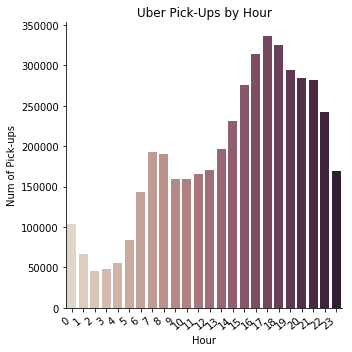

In [72]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="hour", 
               y = 'cnt',
               kind="bar", 
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Hour',
       xlabel='Hour', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## Up Next

Stuff